# **Waste Classification Model**

In this colab, we will be working on buidling a classification model by using VGG16 to classify different types of wastes into either organic or recyclable objects

# **Import**

In [1]:
import torch
import torchvision
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Check if GPU is available and if not change the runtime.

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


# **Download the dataset**
We download the full dataset from [Kaggle](https://www.kaggle.com/datasets/techsash/waste-classification-data/data) and upload to the goole drive to retrieve it

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("techsash/waste-classification-data")

print("Path to dataset files:", path)

100%|██████████| 427M/427M [00:16<00:00, 27.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/techsash/waste-classification-data/versions/1


# **Data Loading**

In [3]:
import os
data_dir = "/root/.cache/kagglehub/datasets/techsash/waste-classification-data/versions/1/DATASET"

# Check if the directory exists
if os.path.isdir(data_dir):
  print(f"Directory '{data_dir}' exists.")
else:
  print(f"Directory '{data_dir}' does not exist.")

# List files and directories within the path (if it exists)
if os.path.exists(data_dir):
    print("Files and directories within the path:")
    for item in os.listdir(data_dir):
        item_path = os.path.join(data_dir, item)
        print(f"- {item} (Directory: {os.path.isdir(item_path)})")

Directory '/root/.cache/kagglehub/datasets/techsash/waste-classification-data/versions/1/DATASET' exists.
Files and directories within the path:
- TRAIN (Directory: True)
- TEST (Directory: True)


In this step, we check each train and test files contain the images

In [4]:
# check if files have images
for root, dirs, files in os.walk(data_dir):
    print(f"Directory: {root}")
    print(f"Subdirectories: {dirs}")
    print(f"Files: {files}")

Directory: /root/.cache/kagglehub/datasets/techsash/waste-classification-data/versions/1/DATASET
Subdirectories: ['TRAIN', 'TEST']
Files: []
Directory: /root/.cache/kagglehub/datasets/techsash/waste-classification-data/versions/1/DATASET/TRAIN
Subdirectories: ['O', 'R']
Files: []
Directory: /root/.cache/kagglehub/datasets/techsash/waste-classification-data/versions/1/DATASET/TRAIN/O
Subdirectories: []
Files: ['O_7999.jpg', 'O_3319.jpg', 'O_826.jpg', 'O_10246.jpg', 'O_7564.jpg', 'O_7135.jpg', 'O_5602.jpg', 'O_11580.jpg', 'O_3868.jpg', 'O_7713.jpg', 'O_6124.jpg', 'O_11630.jpg', 'O_2005.jpg', 'O_2585.jpg', 'O_1458.jpg', 'O_3215.jpg', 'O_7892.jpg', 'O_4734.jpg', 'O_12525.jpg', 'O_5098.jpg', 'O_8395.jpg', 'O_5998.jpg', 'O_7323.jpg', 'O_9178.jpg', 'O_4660.jpg', 'O_3005.jpg', 'O_6911.jpg', 'O_8284.jpg', 'O_51.jpg', 'O_8015.jpg', 'O_8767.jpg', 'O_4764.jpg', 'O_9147.jpg', 'O_9605.jpg', 'O_682.jpg', 'O_9524.jpg', 'O_7717.jpg', 'O_7702.jpg', 'O_4923.jpg', 'O_6949.jpg', 'O_2872.jpg', 'O_2406.jpg',

In [6]:
# normalize image in the dataset to size of 224x224x3
from torchvision import models,transforms,datasets
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
imagenet_format = transforms.Compose([transforms.CenterCrop(224),transforms.ToTensor(),normalize])

# create dataset of classes
dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), imagenet_format)
for x in ['TRAIN', 'TEST']}

# we store the size of train and valid dataset
dset_sizes= {x: len(dsets[x]) for x in ['TRAIN', 'TEST']}

# we store the classes in the variable dset_classes:
dset_classes = dsets['TRAIN'].classes

# print class names
print("Class names:", dset_classes)

Class names: ['O', 'R']


normilize the images into the size of 224x224x3 and check that there should have TRAIN (22564) and TEST (2513)images

In [7]:
# checking dataset size
len(dsets['TRAIN']), len(dsets['TEST'])

(22564, 2513)

# **Data loading and Batching**

here, we load the datasets in batches using Dataloader

In [21]:
# spilt the TRAIN into train (80%) and validation dataset (20%)
train_size = int(0.8*len(dsets['TRAIN']))
val_size = len(dsets['TRAIN']) - train_size
test_dataset = dsets['TEST']
train_dataset, val_dataset = random_split(dsets['TRAIN'], [train_size, val_size])
len(train_dataset), len(val_dataset)

(18051, 4513)

In [22]:
# make dataloader
loader_train = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
loader_valid = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
loader_test = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=2)
len(loader_train), len(loader_valid), len(loader_test)

(565, 142, 79)

# **Visualization**

In [23]:
# A small function to display images:
def imshow(inp, title=None):
# Imshow for Tensor.
  inp = inp.numpy().transpose((1, 2, 0)) # modify dimensions
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = np.clip(std * inp + mean, 0,1) # non-normalize
  plt.imshow(inp)
  if title is not None:
    plt.title(title)

Inputs shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])


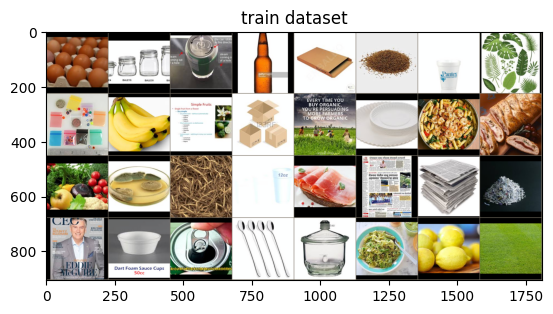

In [25]:
# take a training batch and visualize the images from train dataset
inputs_try, labels_try = next(iter(loader_train))

# check shapes
print("Inputs shape:", inputs_try.shape)
print("Labels shape:", labels_try.shape)

# Make a grid from batch from the
out = torchvision.utils.make_grid(inputs_try)
imshow(out, title='train dataset')

Inputs shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])


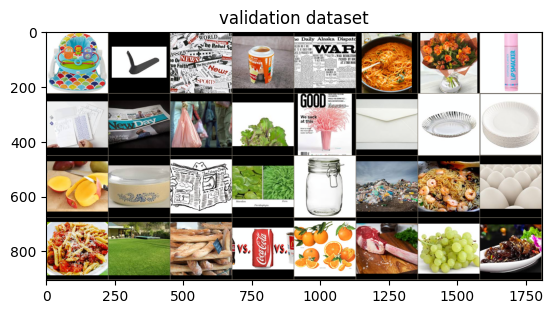

In [26]:
# take a validation batch and visualize the images from validation dataset
inputs_try, labels_try = next(iter(loader_valid))

# check shapes
print("Inputs shape:", inputs_try.shape)
print("Labels shape:", labels_try.shape)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs_try)
imshow(out, title='validation dataset')

Inputs shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])


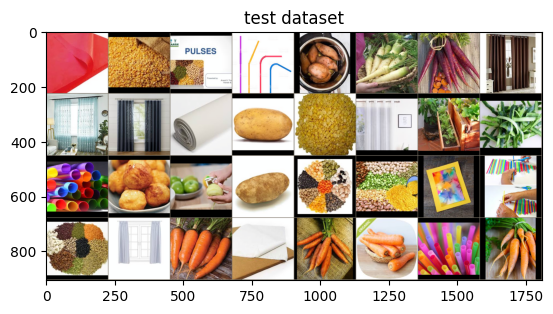

In [27]:
# take a testing batch and visualize the images from test dataset
inputs_try, labels_try = next(iter(loader_test))

# check shapes
print("Inputs shape:", inputs_try.shape)
print("Labels shape:", labels_try.shape)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs_try)
imshow(out, title='test dataset')

# **Adapting the VGG Model**

In [29]:
model_vgg = models.vgg16(pretrained = True)
print(model_vgg)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Our goal is to use the already trained VGG model to classify to 2 class, therefore, we replace the last payer trained for 1000 classes to ones with 2 classes. Also, to freeze the weights of the other layers during training, we set the firld required_grad = False. In this manner no gradient willbe computed for them during backprop and hence no update in the weights.

In [30]:
for param in model_vgg.parameters():
  param.requires_grad = False
  model_vgg.classifier._modules['6'] = nn.Linear(4096, 2)
  model_vgg.classifier._modules['7'] = torch.nn.LogSoftmax(dim = 1)
  print(model_vgg.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=2, bias=True)
  (7): LogSoftmax(dim=1)
)
Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=2, bias=True)
  (7): LogSoftmax(dim=1)
)
Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_fea

In [31]:
# load vgg to device
model_vgg = model_vgg.to(device)

# **Train and test the model**

In [35]:
# creating loss function and optimizer
criterion = nn.NLLLoss()
lr = 0.001

# here we only update the parameters of the linear layer that we added
optimizer_vgg = torch.optim.SGD(model_vgg.classifier[6].parameters(),lr = lr)

In [55]:
class WasteClassifier:
    def __init__(self, model, criterion, optimizer, device):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.training_loss = []
        self.validation_loss = []

    def train(self, train_loader, val_loader, train_size, val_size, epochs=1):
        self.model.train()  # Set the model to training mode

        best_val_loss = float('inf')  # Initialize with a very high value
        best_model_state = None

        for epoch in range(epochs):
        ###################
        # train the model #
        ###################
            running_loss = 0.0
            running_corrects = 0
            for inputs, classes in train_loader:  # Training loop
                inputs = inputs.to(self.device)
                classes = classes.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, classes)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                _, preds = torch.max(outputs.data, dim=1)
                running_loss += loss.data.item()
                running_corrects += torch.sum(preds == classes.data)

            epoch_loss = running_loss / train_size
            epoch_acc = running_corrects.data.item() / train_size
            print('Epoch: {} Training Loss: {:.4f} Training Acc: {:.4f}'.format(
                epoch + 1, epoch_loss, epoch_acc))

            # Validation loop within the training loop
            self.model.eval()  # Set the model to evaluation mode
            val_loss = 0.0
            val_corrects = 0
            with torch.no_grad():
                for inputs, classes in val_loader:  # Validation loop
                    inputs = inputs.to(self.device)
                    classes = classes.to(self.device)
                    outputs = self.model(inputs)
                    loss = self.criterion(outputs, classes)
                    _, preds = torch.max(outputs.data, dim=1)
                    val_loss += loss.data.item()
                    val_corrects += torch.sum(preds == classes.data)

            epoch_val_loss = val_loss / val_size
            epoch_val_acc = val_corrects.data.item() / val_size
            print('Epoch: {} Validation Loss: {:.4f} Validation Acc: {:.4f}'.format(
                epoch + 1, epoch_val_loss, epoch_val_acc))
            self.training_loss.append(epoch_loss)
            self.validation_loss.append(epoch_val_loss)

            # Save the model if it has the lowest validation loss so far
            if epoch_val_loss < best_val_loss:
                best_val_loss = epoch_val_loss
                best_model_state = self.model.state_dict()  # Save model state
                torch.save(best_model_state, 'best_model.pth')
                print("Saving model with best validation loss...")

            self.model.train()  # Set the model back to training mode

        # Load the best model state after training is complete
        self.model.load_state_dict(best_model_state)

    def test(self, dataloader, size):
    ######################
    # validate/Test the model #
    ######################
        self.model.eval()
        predictions = np.zeros(size)
        all_classes = np.zeros(size)
        all_proba = np.zeros((size, 2))
        i = 0
        running_loss = 0.0
        running_corrects = 0
        with torch.no_grad():  # Disable gradient calculation during inference
            for inputs, classes in dataloader:
                inputs = inputs.to(self.device)
                classes = classes.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, classes)
                _, preds = torch.max(outputs.data, dim=1)
                running_loss += loss.data.item()
                running_corrects += torch.sum(preds == classes.data)
                predictions[i:i + len(classes)] = preds.to('cpu').numpy()
                all_classes[i:i + len(classes)] = classes.to('cpu').numpy()
                all_proba[i:i + len(classes), :] = outputs.data.to('cpu').numpy()
                i += len(classes)
        epoch_loss = running_loss / size
        epoch_acc = running_corrects.data.item() / size
        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
        return predictions, all_proba, all_classes

In [56]:
train_model = WasteClassifier(model_vgg, criterion, optimizer_vgg, device)
train_model.train(loader_train, loader_valid, len(train_dataset), len(val_dataset), epochs=10)

Epoch: 1 Training Loss: 0.0050 Training Acc: 0.9382
Epoch: 1 Validation Loss: 0.0047 Validation Acc: 0.9437
Saving model with best validation loss...
Epoch: 2 Training Loss: 0.0052 Training Acc: 0.9349
Epoch: 2 Validation Loss: 0.0047 Validation Acc: 0.9457
Saving model with best validation loss...
Epoch: 3 Training Loss: 0.0051 Training Acc: 0.9382
Epoch: 3 Validation Loss: 0.0047 Validation Acc: 0.9442
Epoch: 4 Training Loss: 0.0051 Training Acc: 0.9373
Epoch: 4 Validation Loss: 0.0047 Validation Acc: 0.9448
Saving model with best validation loss...
Epoch: 5 Training Loss: 0.0050 Training Acc: 0.9379
Epoch: 5 Validation Loss: 0.0047 Validation Acc: 0.9444
Saving model with best validation loss...
Epoch: 6 Training Loss: 0.0049 Training Acc: 0.9377
Epoch: 6 Validation Loss: 0.0047 Validation Acc: 0.9446
Saving model with best validation loss...
Epoch: 7 Training Loss: 0.0049 Training Acc: 0.9388
Epoch: 7 Validation Loss: 0.0046 Validation Acc: 0.9459
Saving model with best validation 

visulize the loss

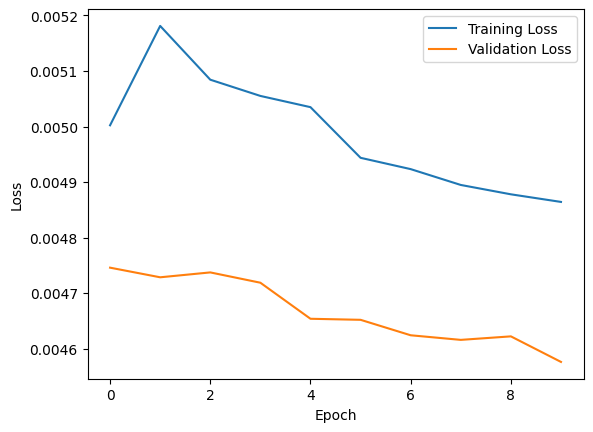

In [57]:
plt.plot(train_model.training_loss, label='Training Loss')
plt.plot(train_model.validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# **Test the model**

retrive the best model from the 'best_model.path'

In [58]:
import torch
from sklearn.metrics import classification_report

# Load the best model
best_model = torch.load('best_model.pth')
train_model.model.load_state_dict(best_model)  # Load the state dict into the model

#test the model
precision, recall, f1_score = train_model.test(loader_test, len(test_dataset))

<ipython-input-58-36688824b804>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load('best_model.pth')


Loss: 0.0061 Acc: 0.9184


# **Model Performance Statements**

calcualte the model performance in term of precision, recall

In [63]:
# calculate the performance of best model
predicted_labels, _, actual_labels = train_model.test(loader_test, len(test_dataset))

# Ensure predicted_labels and actual_labels are 1D arrays for classification_report
predicted_labels = predicted_labels.flatten()
actual_labels = actual_labels.flatten()

#generate the classification report
print(classification_report(actual_labels, predicted_labels))

Loss: 0.0061 Acc: 0.9184
              precision    recall  f1-score   support

         0.0       0.89      0.98      0.93      1401
         1.0       0.96      0.85      0.90      1112

    accuracy                           0.92      2513
   macro avg       0.93      0.91      0.92      2513
weighted avg       0.92      0.92      0.92      2513



The model for benchmarking from [Kaggle](https://www.kaggle.com/code/trushildhokiya/watse-classification-pytorch-modified-lenet/notebook) is using LeNet Network with architecure like following

In [78]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.model = nn.Sequential(
            # first layer
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),

            # second layer
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            # third layer
            nn.Flatten(),
            nn.Linear(in_features=29*29*16, out_features=120),
            nn.ReLU(),

            # fourth layer
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),

            # output layer
            nn.Linear(in_features=84, out_features=2)
        )

    def forward(self, x):
        return self.model(x)

the performance of LeNet is: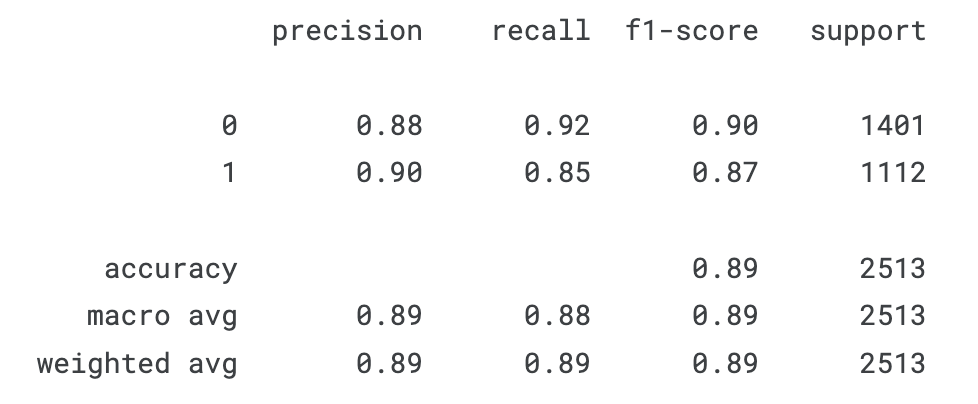

Therefore, our model is outperforming